# 2D Face Data Extraction

##### Optional Code Cell For Development/Testing Mode (Local Copy)
##### Uncomment and run this cell instead of the pip cell above


# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))

print("Loading ras-commander from local dev copy")
from ras_commander import *


# HEC-RAS 2D Detail Face Data Extraction Examples

This notebook demonstrates how to extract detailed 2D face data, display individual cell face results and calculate a discharge weighted velocity using a user-provided profile line located where cell faces are perpendicular to flow. 


## Package Installation and Environment Setup
Uncomment and run package installation commands if needed

In [1]:
# Install ras-commander from pip (uncomment to install if needed)
#!pip install ras-commander
# This installs ras-commander and all dependencies

In [2]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import *

# Additional imports for this notebook
import h5py
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
import scipy
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython import display
import psutil  # For getting system CPU info
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import subprocess
import os
import shutil
from datetime import datetime, timedelta
from pathlib import Path  # Ensure pathlib is imported for file operations
import pyproj
from shapely.geometry import Point, LineString, Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
import logging
import rasterio
from rasterio.plot import show

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📦 PIP PACKAGE MODE: Loading installed ras-commander


✓ Loaded: c:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\ras_commander\__init__.py


Note: This notebook relies on the Chippewa 2D Project along with:
 - A user-generated GeoJSON containing the proposed profile lines
 - An example is provided in the "data" subfolder with name profile_lines_chippewa2D.geojson

In [3]:
# Extract the Chippewa_2D example project using static method
chippewa_path = RasExamples.extract_project("Chippewa_2D", suffix="13")
print(f"Extracted project to: {chippewa_path}")

# Verify the path exists
print(f"Chippewa_2D project exists: {chippewa_path.exists()}")

# Initialize the RAS project using the default global ras object
init_ras_project(chippewa_path, "6.6")
from ras_commander import get_logger  # Import after sys.path is set if not installed
logger = get_logger(__name__)
logger.info(f"Chippewa_2D project initialized with folder: {ras.project_folder}")

# Define the plan number to execute
plan_number = "02"

# Execute Plan 02 using RasCmdr with skip_existing=True
RasCmdr.compute_plan(
    plan_number,
    ras_object=ras,
    skip_existing=True,
    num_cores=2
)

2025-12-16 21:37:01 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\Example_Projects_6_6.zip


2025-12-16 21:37:01 - ras_commander.RasExamples - INFO - Loading project data from CSV...


2025-12-16 21:37:01 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.


2025-12-16 21:37:01 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----


2025-12-16 21:37:01 - ras_commander.RasExamples - INFO - Extracting project 'Chippewa_2D' as 'Chippewa_2D_13'


2025-12-16 21:37:01 - ras_commander.RasExamples - INFO - Folder 'Chippewa_2D_13' already exists. Deleting existing folder...


2025-12-16 21:37:01 - ras_commander.RasExamples - INFO - Existing folder 'Chippewa_2D_13' has been deleted.


2025-12-16 21:37:01 - ras_commander.RasExamples - INFO - Successfully extracted project 'Chippewa_2D' to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13


2025-12-16 21:37:01 - ras_commander.rasmap - INFO - Successfully parsed RASMapper file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.rasmap


2025-12-16 21:37:01 - __main__ - INFO - Chippewa_2D project initialized with folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13


2025-12-16 21:37:01 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13


2025-12-16 21:37:01 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02


2025-12-16 21:37:01 - ras_commander.RasUtils - INFO - Successfully updated file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02


2025-12-16 21:37:01 - ras_commander.RasCmdr - INFO - Set number of cores to 2 for plan: 02


2025-12-16 21:37:01 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:


2025-12-16 21:37:01 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.prj" "C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02"


Extracted project to: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13
Chippewa_2D project exists: True


2025-12-16 21:40:36 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 02


2025-12-16 21:40:36 - ras_commander.RasCmdr - INFO - Total run time for plan 02: 214.78 seconds


True

In [4]:
# Show ras object info
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,02,04,01,100ft Sediment,6.40,100ft Sediment,"02apr2019,0000,05may2019,2400",2MIN,30MIN,-1,...,dss,1,PARDISO (Direct),Perimeter 1,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,04,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


In [5]:
ras.unsteady_df

,unsteady_number,full_path,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Gridded Source
0,04,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,2019-test,6.40,0,Disable,No Wind Forces,0,DSS


In [6]:
ras.boundaries_df 

,unsteady_number,boundary_condition_number,river_reach_name,river_station,storage_area_name,pump_station_name,bc_type,hydrograph_type,Interval,DSS Path,...,hydrograph_values,DSS File,full_path,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Gridded Source
0,04,1,,,,,Flow Hydrograph,Flow Hydrograph,1DAY,,...,"[5770, 5760, 6200, 5630, 6400, 6970, 6610, 610...",NaN,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,2019-test,6.40,0,Disable,No Wind Forces,0,DSS
1,04,2,,,,,Flow Hydrograph,Flow Hydrograph,1DAY,/MISSISSIPPI R LAKE PEPIN/765.51/FLOW/01JAN197...,...,"[11800, 12300, 12400, 12200, 12400, 11900, 117...",..\..\2018\ChippewaRiverBedload\RAS_Final\Sedi...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,2019-test,6.40,0,Disable,No Wind Forces,0,DSS
2,04,3,,,,,Stage Hydrograph,Stage Hydrograph,1DAY,/MISSISSIPPI R LOWER POOL 4/754.00/STAGE/01JAN...,...,"[666.68, 666.81, 666.82, 666.8, 666.83, 666.87...",..\..\2018\ChippewaRiverBedload\RAS_Final\Sedi...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,2019-test,6.40,0,Disable,No Wind Forces,0,DSS
3,04,4,,,,,Flow Hydrograph,Flow Hydrograph,1DAY,,...,"[18093.43, 20945.317590.3917795.6817894.251879...",NaN,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,2019-test,6.40,0,Disable,No Wind Forces,0,DSS
4,04,5,,,,,Stage Hydrograph,Stage Hydrograph,1DAY,,...,"[679.743, 680.239, 679.775, 679.757, 679.75, 6...",NaN,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,2019-test,6.40,0,Disable,No Wind Forces,0,DSS


In [7]:
ras.get_hdf_entries()

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,02,04,01,100ft Sediment,6.40,100ft Sediment,"02apr2019,0000,05may2019,2400",2MIN,30MIN,-1,...,dss,1,PARDISO (Direct),Perimeter 1,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,04,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


# Find Paths for Results and Geometry HDF's

In [8]:
# Define the HDF input path as Plan Number

plan_number = "02"  # Assuming we're using plan 01 as in the previous code


In [9]:
# Get the plan HDF path for the plan_number defined above
plan_hdf_path = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'HDF_Results_Path'].values[0]

In [10]:
plan_hdf_path

'C:\\Users\\billk_clb\\anaconda3\\envs\\rascmdr_piptest\\Lib\\site-packages\\examples\\example_projects\\Chippewa_2D_13\\Chippewa_2D.p02.hdf'

In [11]:
# Alternate: Get the geometry HDF path if you are extracting geometry elements from the geometry HDF 
geom_hdf_path = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'Geom Path'].values[0] + '.hdf'

In [12]:
geom_hdf_path

'C:\\Users\\billk_clb\\anaconda3\\envs\\rascmdr_piptest\\Lib\\site-packages\\examples\\example_projects\\Chippewa_2D_13\\Chippewa_2D.g01.hdf'

In [13]:
# Example: Extract runtime and compute time data
print("\nExample 2: Extracting runtime and compute time data")
runtime_df = HdfResultsPlan.get_runtime_data(hdf_path=plan_number)
if runtime_df is not None:
    runtime_df
else:
    print("No runtime data found.")

2025-12-16 21:40:36 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfResultsPlan - INFO - Extracting Plan Information from: Chippewa_2D.p02.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfResultsPlan - INFO - Plan Name: 100ft Sediment


2025-12-16 21:40:36 - ras_commander.hdf.HdfResultsPlan - INFO - Simulation Duration (hours): 816.0



Example 2: Extracting runtime and compute time data


In [14]:
# For all of the RasGeomHdf Class Functions, we will use geom_hdf_path
print(geom_hdf_path)

# For the example project, plan 02 is associated with geometry 09
# If you want to call the geometry by number, call RasHdfGeom functions with a number
# Otherwise, if you want to look up geometry hdf path by plan number, follow the logic in the previous code cells

C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


In [15]:
# Use HdfUtils for extracting projection
print("\nExtracting Projection from HDF")
projection = HdfBase.get_projection(hdf_path=geom_hdf_path)
if projection:
    print(f"Projection: {projection}")
else:
    print("No projection information found.")

2025-12-16 21:40:36 - ras_commander.hdf.HdfBase - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF file projection attribute: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2. RASMapper projection file C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\.Winona_Upload\LifeSim model\Winona Levee SQRA 2019\RAS\AW\MMC_Projection.prj found in RASMapper file, but was invalid
To fix this:
1. Open RASMapper
2. Click Map > Set Projection
3. Select an appropriate projection file or coordinate system
4. Save the RASMapper project



Extracting Projection from HDF
No projection information found.


In [16]:
# Set the  to USA Contiguous Albers Equal Area Conic (USGS version)
# Note, we would usually call the projection function in HdfMesh but the projection is not set in this example project
projection = 'EPSG:5070'  

In [17]:
# Use HdfPlan for geometry-related operations
print("\nExample: Extracting Base Geometry Attributes")
geom_attrs = HdfPlan.get_geometry_information(geom_hdf_path)

if not geom_attrs.empty:
    # Display the DataFrame directly
    print("Base Geometry Attributes:")
    geom_attrs
else:
    print("No base geometry attributes found.")


2025-12-16 21:40:36 - ras_commander.hdf.HdfPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfPlan - INFO - Getting geometry attributes from C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfPlan - INFO - Checking for Geometry group in C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfPlan - INFO - Getting root level geometry attributes


2025-12-16 21:40:36 - ras_commander.hdf.HdfPlan - INFO - Successfully extracted 17 root level geometry attributes



Example: Extracting Base Geometry Attributes
Base Geometry Attributes:


In [18]:
# Use HdfMesh for geometry-related operations
print("\nExample 3: Listing 2D Flow Area Names")
flow_area_names = HdfMesh.get_mesh_area_names(geom_hdf_path)
print("2D Flow Area Names:", flow_area_names)

2025-12-16 21:40:36 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf



Example 3: Listing 2D Flow Area Names
2D Flow Area Names: ['Perimeter 1']


In [19]:
# Example: Get 2D Flow Area Attributes (get_geom_2d_flow_area_attrs)
print("\nExample: Extracting 2D Flow Area Attributes")
flow_area_attributes = HdfMesh.get_mesh_area_attributes(geom_hdf_path)
flow_area_attributes


2025-12-16 21:40:36 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf



Example: Extracting 2D Flow Area Attributes


,Value
Name,b'Perimeter 1'
Locked,0
Mann,0.06
Multiple Face Mann n,1
Composite LC,1
Cell Vol Tol,0.01
Cell Min Area Fraction,0.01
Face Profile Tol,0.01
Face Area Tol,0.01
Face Conv Ratio,0.02


In [20]:
# Example: Get 2D Flow Area Perimeter Polygons (mesh_areas)
print("\nExample: Extracting 2D Flow Area Perimeter Polygons")
mesh_areas = HdfMesh.get_mesh_areas(geom_hdf_path)  # Corrected function name

2025-12-16 21:40:36 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF file projection attribute: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2. RASMapper projection file C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\.Winona_Upload\LifeSim model\Winona Levee SQRA 2019\RAS\AW\MMC_Projection.prj found in RASMapper file, but was invalid
To fix this:
1. Open RASMapper
2. Click Map > Set Projection
3. Select an appropriate projection file or coordinate system
4. Save the RASMapper project



Example: Extracting 2D Flow Area Perimeter Polygons


In [21]:
# Example: Extract mesh cell faces
print("\nExample: Extracting mesh cell faces")

# Get mesh cell faces using the standardize_input decorator for consistent file handling
mesh_cell_faces = HdfMesh.get_mesh_cell_faces(geom_hdf_path)

# Display the first few rows of the mesh cell faces GeoDataFrame
print("First few rows of mesh cell faces:")
mesh_cell_faces.head()

2025-12-16 21:40:36 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:36 - ras_commander.hdf.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF file projection attribute: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2. RASMapper projection file C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\.Winona_Upload\LifeSim model\Winona Levee SQRA 2019\RAS\AW\MMC_Projection.prj found in RASMapper file, but was invalid
To fix this:
1. Open RASMapper
2. Click Map > Set Projection
3. Select an appropriate projection file or coordinate system
4. Save the RASMapper project



Example: Extracting mesh cell faces
First few rows of mesh cell faces:


,mesh_name,face_id,geometry
0,Perimeter 1,0,"LINESTRING (1027231.594 7857846.138, 1026833.9..."
1,Perimeter 1,1,"LINESTRING (1026833.966 7857797.923, 1026849.8..."
2,Perimeter 1,2,"LINESTRING (1026849.886 7857613.488, 1027249.0..."
3,Perimeter 1,3,"LINESTRING (1027249.03 7857618.591, 1027231.59..."
4,Perimeter 1,4,"LINESTRING (1027231.594 7857846.138, 1027231.5..."


In [22]:
# Set the projection to USA Contiguous Albers Equal Area Conic (USGS version)
# Note, we would usually call the projection function in HdfMesh but the projection is not set in this example project
projection = 'EPSG:5070'  # NAD83 / Conus Albers


Example: Finding the nearest cell face to a given point
Nearest cell face to point (1025677.0, 7853731.0):
Face ID: 209
Distance: 5.74 units


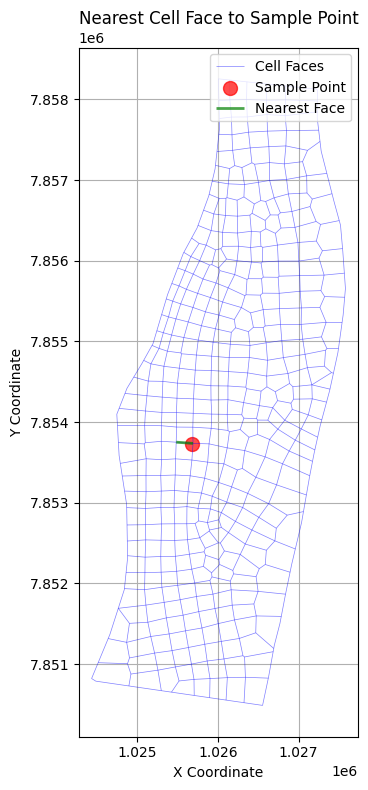

In [23]:
# Example Function: Find the nearest cell face to a given point
# This provides enough basic information the face cell logic in the notebook

def find_nearest_cell_face(point, cell_faces_df):
    """
    Find the nearest cell face to a given point.

    Args:
        point (shapely.geometry.Point): The input point.
        cell_faces_df (GeoDataFrame): DataFrame containing cell face linestrings.

    Returns:
        int: The face_id of the nearest cell face.
        float: The distance to the nearest cell face.
    """
    # Calculate distances from the input point to all cell faces
    distances = cell_faces_df.geometry.distance(point)

    # Find the index of the minimum distance
    nearest_index = distances.idxmin()

    # Get the face_id and distance of the nearest cell face
    nearest_face_id = cell_faces_df.loc[nearest_index, 'face_id']
    nearest_distance = distances[nearest_index]

    return nearest_face_id, nearest_distance

# Example usage
print("\nExample: Finding the nearest cell face to a given point")

# Create a sample point (you can replace this with any point of interest)
from shapely.geometry import Point
from geopandas import GeoDataFrame

# Create the sample point with the same CRS as mesh_cell_faces
sample_point = GeoDataFrame(
    {'geometry': [Point(1025677, 7853731)]}, 
    crs=mesh_cell_faces.crs
)

if not mesh_cell_faces.empty and not sample_point.empty:
    nearest_face_id, distance = find_nearest_cell_face(sample_point.geometry.iloc[0], mesh_cell_faces)
    print(f"Nearest cell face to point {sample_point.geometry.iloc[0].coords[0]}:")
    print(f"Face ID: {nearest_face_id}")
    print(f"Distance: {distance:.2f} units")

    # Visualize the result
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot all cell faces
    mesh_cell_faces.plot(ax=ax, color='blue', linewidth=0.5, alpha=0.5, label='Cell Faces')
    
    # Plot the sample point
    sample_point.plot(ax=ax, color='red', markersize=100, alpha=0.7, label='Sample Point')
    
    # Plot the nearest cell face
    nearest_face = mesh_cell_faces[mesh_cell_faces['face_id'] == nearest_face_id]
    nearest_face.plot(ax=ax, color='green', linewidth=2, alpha=0.7, label='Nearest Face')
    
    # Set labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Nearest Cell Face to Sample Point')
    
    # Add legend and grid
    ax.legend()
    ax.grid(True)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
else:
    print("Unable to perform nearest cell face search due to missing data.")


2025-12-16 21:40:37 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:37 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:37 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:37 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:37 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:37 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:37 - ras_commander.hdf.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF file projection attribute: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2. RASMapper projection file C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\.Winona_Upload\LifeSim model\Winona Levee SQRA 2019\RAS\AW\MMC_Projection.prj found in RASMapper file, but was invalid
To fix this:
1. Open RASMapper
2. Click Map > Set Projection
3. Select an appropriate projection file or coordinate system
4. Save the RASMapper project



Example: Extracting mesh cell faces and plotting with profile lines
First few rows of mesh cell faces:


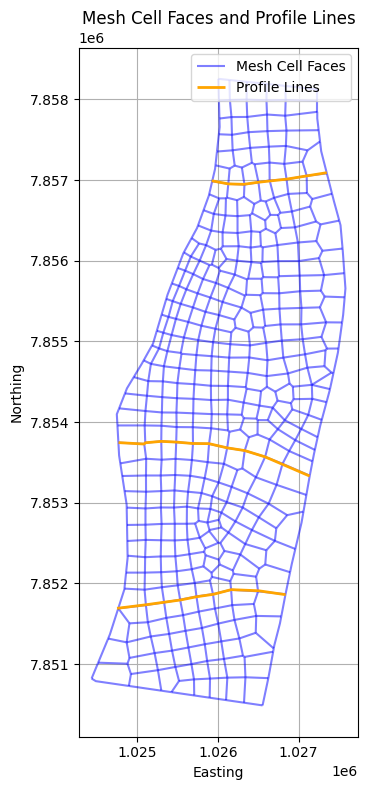

In [24]:
# Example: Extract mesh cell faces and plot with profile lines
print("\nExample: Extracting mesh cell faces and plotting with profile lines")

# Get mesh cell faces
mesh_cell_faces = HdfMesh.get_mesh_cell_faces(geom_hdf_path)

# Display the first few rows of the mesh cell faces DataFrame
print("First few rows of mesh cell faces:")
mesh_cell_faces

# Load the GeoJSON file for profile lines
geojson_path = Path(r'data/profile_lines_chippewa2D.geojson')  # Update with the correct path
profile_lines_gdf = gpd.read_file(geojson_path)

# Set the Coordinate Reference System (CRS) to EPSG:5070
profile_lines_gdf = profile_lines_gdf.set_crs(epsg=5070, allow_override=True)

# Plot the mesh cell faces and profile lines together
fig, ax = plt.subplots(figsize=(12, 8))
mesh_cell_faces.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k', label='Mesh Cell Faces')
profile_lines_gdf.plot(ax=ax, color='orange', linewidth=2, label='Profile Lines')

# Set labels and title
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_title('Mesh Cell Faces and Profile Lines')

# Add grid and legend
ax.grid(True)
ax.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

2025-12-16 21:40:37 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:37 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:37 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:37 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:37 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:37 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:37 - ras_commander.hdf.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF file projection attribute: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2. RASMapper projection file C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\.Winona_Upload\LifeSim model\Winona Levee SQRA 2019\RAS\AW\MMC_Projection.prj found in RASMapper file, but was invalid
To fix this:
1. Open RASMapper
2. Click Map > Set Projection
3. Select an appropriate projection file or coordinate system
4. Save the RASMapper project



Example: Extracting mesh cell faces near profile lines
First few rows of mesh cell faces:


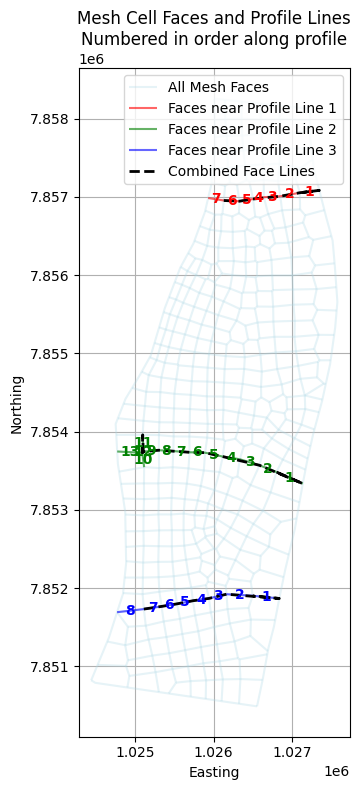


Original ordered faces near profile lines:

Combined profile-to-faceline results:


,profile_name,geometry
0,Profile Line 1,"LINESTRING (1027100.412 7857052.854, 1027350.3..."
1,Profile Line 2,"LINESTRING (1026801.09 7853483.399, 1027138.39..."
2,Profile Line 3,"LINESTRING (1026498.193 7851901.653, 1026838.2..."


In [25]:
# Example: Extracting mesh cell faces near profile lines
print("\nExample: Extracting mesh cell faces near profile lines")

# Get mesh cell faces using HdfMesh class
mesh_cell_faces = HdfMesh.get_mesh_cell_faces(geom_hdf_path)

# Display the first few rows of the mesh cell faces DataFrame
print("First few rows of mesh cell faces:")
mesh_cell_faces

# Load the GeoJSON file for profile lines
geojson_path = Path(r'data/profile_lines_chippewa2D.geojson')  # Update with the correct path
profile_lines_gdf = gpd.read_file(geojson_path)

# Set the Coordinate Reference System (CRS) to EPSG:5070
profile_lines_gdf = profile_lines_gdf.set_crs(epsg=5070, allow_override=True)

# Initialize a dictionary to store faces near each profile line
faces_near_profile_lines = {}

# Define distance threshold (10 ft converted to meters)
distance_threshold = 10
angle_threshold = 60  # degrees

# Function to calculate the smallest angle between two lines or line segments.
def calculate_angle(line):
    if isinstance(line, LineString):
        x_diff = line.xy[0][-1] - line.xy[0][0]
        y_diff = line.xy[1][-1] - line.xy[1][0]
    else:
        x_diff = line[1][0] - line[0][0]
        y_diff = line[1][1] - line[0][1]
    
    angle = np.degrees(np.arctan2(y_diff, x_diff))
    return angle % 360 if angle >= 0 else (angle + 360) % 360

# Function to break line into segments
def break_line_into_segments(line, segment_length):
    segments = []
    segment_angles = []
    
    distances = np.arange(0, line.length, segment_length)
    if distances[-1] != line.length:
        distances = np.append(distances, line.length)
        
    for i in range(len(distances)-1):
        point1 = line.interpolate(distances[i])
        point2 = line.interpolate(distances[i+1])
        segment = LineString([point1, point2])
        segments.append(segment)
        segment_angles.append(calculate_angle([point1.coords[0], point2.coords[0]]))
        
    return segments, segment_angles

# Function to calculate angle difference accounting for 180 degree equivalence
def angle_difference(angle1, angle2):
    diff = abs(angle1 - angle2) % 180
    return min(diff, 180 - diff)

# Function to order faces along profile line
def order_faces_along_profile(profile_line, faces_gdf):
    profile_start = Point(profile_line.coords[0])
    
    faces_with_dist = []
    for idx, face in faces_gdf.iterrows():
        face_start = Point(face.geometry.coords[0])
        dist = profile_start.distance(face_start)
        faces_with_dist.append((idx, dist))
    
    faces_with_dist.sort(key=lambda x: x[1])
    return [x[0] for x in faces_with_dist]

# Function to combine ordered faces into single linestring
def combine_faces_to_linestring(ordered_faces_gdf):
    coords = []
    for _, face in ordered_faces_gdf.iterrows():
        if not coords:  # First face - add all coordinates
            coords.extend(list(face.geometry.coords))
        else:  # Subsequent faces - add only end coordinate
            coords.append(face.geometry.coords[-1])
    return LineString(coords)

# Initialize GeoDataFrame for final profile-to-faceline results
profile_to_faceline = gpd.GeoDataFrame(columns=['profile_name', 'geometry'], crs=profile_lines_gdf.crs)

# Iterate through each profile line
for index, profile_line in profile_lines_gdf.iterrows():
    profile_geom = profile_line.geometry
    
    # Break profile line into segments
    segments, segment_angles = break_line_into_segments(profile_geom, distance_threshold)
    
    # Initialize set to store nearby faces
    nearby_faces = set()
    
    # For each face, check distance to segments and angle difference
    for face_idx, face in mesh_cell_faces.iterrows():
        face_geom = face.geometry
        
        if isinstance(face_geom, LineString):
            face_angle = calculate_angle(face_geom)
            
            for segment, segment_angle in zip(segments, segment_angles):
                if face_geom.distance(segment) <= distance_threshold:
                    if angle_difference(face_angle, segment_angle) <= angle_threshold:
                        nearby_faces.add(face_idx)
                        break
    
    # Convert the set of indices back to a GeoDataFrame
    nearby_faces_gdf = mesh_cell_faces.loc[list(nearby_faces)]
    
    # Order faces along profile line
    ordered_indices = order_faces_along_profile(profile_geom, nearby_faces_gdf)
    ordered_faces_gdf = nearby_faces_gdf.loc[ordered_indices]
    
    # Combine ordered faces into single linestring
    combined_linestring = combine_faces_to_linestring(ordered_faces_gdf)
    
    # Add to profile_to_faceline GeoDataFrame
    new_row = gpd.GeoDataFrame({'profile_name': [profile_line['Name']], 
                               'geometry': [combined_linestring]}, 
                              crs=profile_lines_gdf.crs)
    profile_to_faceline = pd.concat([profile_to_faceline, new_row], ignore_index=True)
    
    # Store the ordered faces in the dictionary
    faces_near_profile_lines[profile_line['Name']] = ordered_faces_gdf

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all mesh cell faces in light blue
mesh_cell_faces.plot(ax=ax, color='lightblue', alpha=0.3, edgecolor='k', label='All Mesh Faces')

# Plot selected faces for each profile line with numbers
colors = ['red', 'green', 'blue']
for (profile_name, faces), color in zip(faces_near_profile_lines.items(), colors):
    if not faces.empty:
        faces.plot(ax=ax, color=color, alpha=0.6, label=f'Faces near {profile_name}')
        
        # Add numbers to faces
        for i, (idx, face) in enumerate(faces.iterrows()):
            midpoint = face.geometry.interpolate(0.5, normalized=True)
            ax.text(midpoint.x, midpoint.y, str(i+1), 
                   color=color, fontweight='bold', ha='center', va='center')

# Plot the combined linestrings
profile_to_faceline.plot(ax=ax, color='black', linewidth=2, 
                        linestyle='--', label='Combined Face Lines')

# Set labels and title
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_title('Mesh Cell Faces and Profile Lines\nNumbered in order along profile')

# Add grid and legend
ax.grid(True)
ax.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Display the results
print("\nOriginal ordered faces near profile lines:")
faces_near_profile_lines

print("\nCombined profile-to-faceline results:")
profile_to_faceline

-----

In [26]:
# Get face property tables with error handling
face_property_tables = HdfMesh.get_mesh_face_property_tables(geom_hdf_path)
face_property_tables

2025-12-16 21:40:40 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:40 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:40 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:40 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


{'Perimeter 1':       Face ID          Z       Area Wetted Perimeter Manning's n
 0           0  683.78314        0.0              0.0  0.06680043
 1           0  683.98315  25.314476        311.06384  0.06680043
 2           0   684.1409   77.88681         355.3648  0.06600185
 3           0   684.1893  98.404495        368.92633  0.06575739
 4           0   684.5791  249.17476         400.5631  0.06531201
 ...       ...        ...        ...              ...         ...
 5183      812  683.02405   1228.017        475.78708  0.06334631
 5184      813   683.6363        0.0              0.0  0.07539803
 5185      813   683.8363  13.135144        199.78789  0.07539803
 5186      813   683.9459  45.552128        391.64612  0.07541533
 5187      813  683.94946   51.69725         397.8351  0.07541589
 
 [5188 rows x 5 columns]}

2025-12-16 21:40:40 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-12-16 21:40:40 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-12-16 21:40:40 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-12-16 21:40:40 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-12-16 21:40:40 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-12-16 21:40:40 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-12-16 21:40:40 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-12-16 21:40:40 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-12-16 21:40:40 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-12-16 21:40:40 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-12-16 21:40:40 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-12-16 21:40:40 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


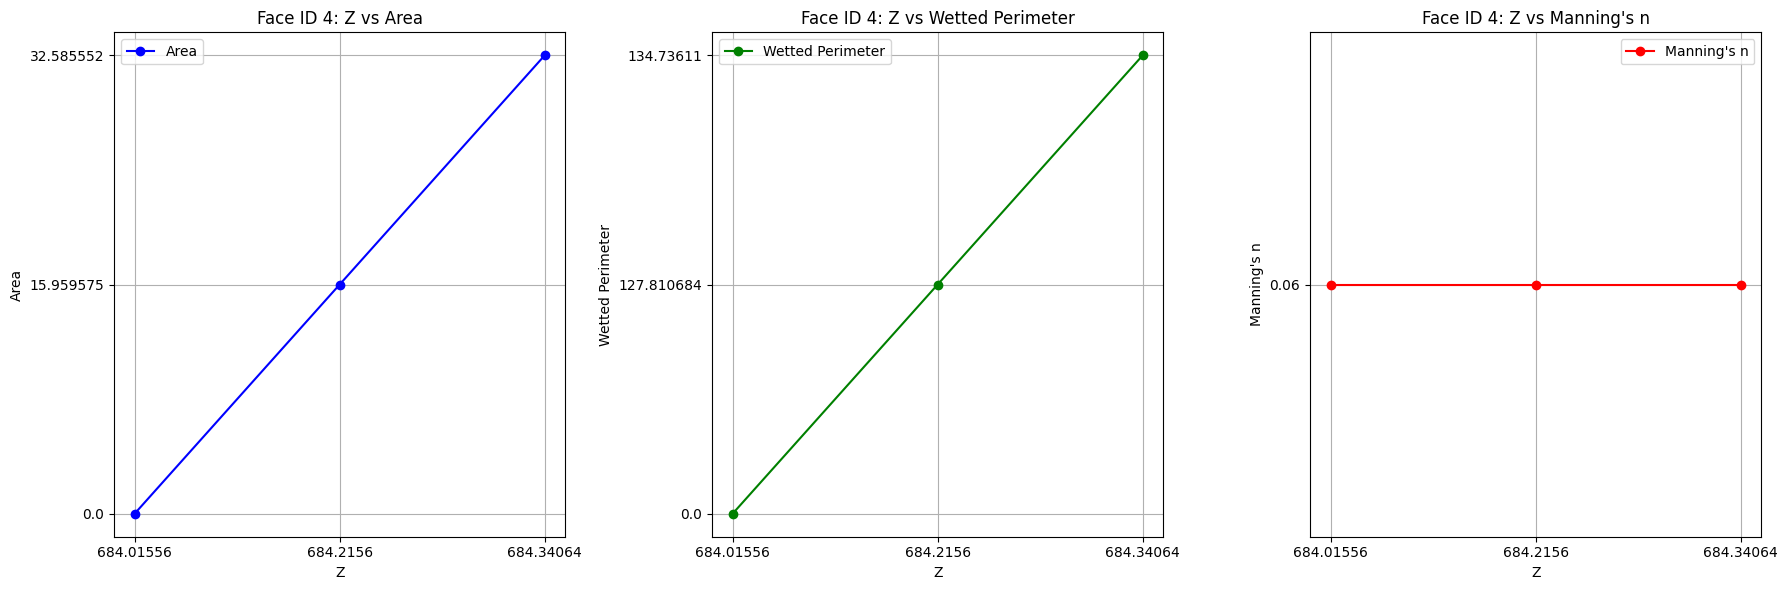

In [27]:
# Extract the face property table for Face ID 4 and display it
import matplotlib.pyplot as plt

face_id = 4
face_properties = face_property_tables['Perimeter 1'][face_property_tables['Perimeter 1']['Face ID'] == face_id]

# Create subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Z vs Area
axs[0].plot(face_properties['Z'], face_properties['Area'], marker='o', color='blue', label='Area')
axs[0].set_title(f'Face ID {face_id}: Z vs Area')
axs[0].set_xlabel('Z')
axs[0].set_ylabel('Area')
axs[0].grid(True)
axs[0].legend()

# Plot Z vs Wetted Perimeter
axs[1].plot(face_properties['Z'], face_properties['Wetted Perimeter'], marker='o', color='green', label='Wetted Perimeter')
axs[1].set_title(f'Face ID {face_id}: Z vs Wetted Perimeter')
axs[1].set_xlabel('Z')
axs[1].set_ylabel('Wetted Perimeter')
axs[1].grid(True)
axs[1].legend()

# Plot Z vs Manning's n
axs[2].plot(face_properties['Z'], face_properties["Manning's n"], marker='o', color='red', label="Manning's n")
axs[2].set_title(f'Face ID {face_id}: Z vs Manning\'s n')
axs[2].set_xlabel('Z')
axs[2].set_ylabel("Manning's n")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()


In [28]:
# Get mesh timeseries output
# Get mesh areas from previous code cell
mesh_areas = HdfMesh.get_mesh_area_names(geom_hdf_path)

mesh_name = mesh_areas[0]  # Use the first 2D flow area name
timeseries_da = HdfResultsMesh.get_mesh_timeseries(plan_hdf_path, mesh_name, "Water Surface")



2025-12-16 21:40:40 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:40 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf


In [29]:
print(f"\nMesh Timeseries Output (Water Surface) for {mesh_name}:")
timeseries_da


Mesh Timeseries Output (Water Surface) for Perimeter 1:


<xarray.DataArray (time: 1633, cell_id: 433)> Size: 3MB
array([[681.284  , 681.25146, 681.22766, ..., 685.05927, 680.1254 ,
        683.6363 ],
       [681.2948 , 681.26215, 681.23834, ..., 685.05927, 680.1254 ,
        683.6363 ],
       [681.30634, 681.2736 , 681.2497 , ..., 685.05927, 680.1254 ,
        683.6363 ],
       ...,
       [680.89825, 680.8681 , 680.8455 , ..., 685.05927, 680.1254 ,
        683.7824 ],
       [680.8906 , 680.8606 , 680.8381 , ..., 685.05927, 680.1254 ,
        683.7824 ],
       [680.8839 , 680.854  , 680.83167, ..., 685.05927, 680.1254 ,
        683.7824 ]], shape=(1633, 433), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 13kB 2019-04-02 ... 2019-05-06
  * cell_id  (cell_id) int64 3kB 0 1 2 3 4 5 6 7 ... 426 427 428 429 430 431 432
Attributes:
    units:      ft
    mesh_name:  Perimeter 1
    variable:   Water Surface

In [30]:
# Get mesh cells timeseries output
cells_timeseries_ds = HdfResultsMesh.get_mesh_cells_timeseries(plan_hdf_path, mesh_name)

2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Shear Stress' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Bed Elevation' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Precipitation Rate' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Infiltration Rate' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Evaporation Rate' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Percolation Rate' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Elevation' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Depth' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Flow' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Velocity' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Velocity X' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Groundwater Velocity Y' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Friction Term' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Pressure Gradient Term' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Shear Stress' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Tangential Velocity' not found in the HDF file for mesh 'Perimeter 1'. Skipping.


In [31]:
print("\nMesh Cells Timeseries Output:")
cells_timeseries_ds


Mesh Cells Timeseries Output:


{'Perimeter 1': <xarray.Dataset> Size: 13MB
 Dimensions:        (time: 1633, cell_id: 433, face_id: 814)
 Coordinates:
   * time           (time) datetime64[ns] 13kB 2019-04-02 ... 2019-05-06
   * cell_id        (cell_id) int64 3kB 0 1 2 3 4 5 6 ... 427 428 429 430 431 432
   * face_id        (face_id) int64 7kB 0 1 2 3 4 5 6 ... 808 809 810 811 812 813
 Data variables:
     Water Surface  (time, cell_id) float32 3MB 681.3 681.3 681.2 ... 680.1 683.8
     Face Velocity  (time, face_id) float32 5MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 -0.0
     Face Flow      (time, face_id) float32 5MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
 Attributes:
     mesh_name:   Perimeter 1
     start_time:  2019-04-02 00:00:00}

In [32]:
# Get mesh faces timeseries output
faces_timeseries_ds = HdfResultsMesh.get_mesh_faces_timeseries(plan_hdf_path, mesh_name)

2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf


2025-12-16 21:40:40 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.p02.hdf


In [33]:
print("\nMesh Faces Timeseries Output:")
faces_timeseries_ds



Mesh Faces Timeseries Output:


<xarray.Dataset> Size: 11MB
Dimensions:        (time: 1633, face_id: 814)
Coordinates:
  * time           (time) datetime64[ns] 13kB 2019-04-02 ... 2019-05-06
  * face_id        (face_id) int64 7kB 0 1 2 3 4 5 6 ... 808 809 810 811 812 813
Data variables:
    face_velocity  (time, face_id) float32 5MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 -0.0
    face_flow      (time, face_id) float32 5MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    units:      ft/s
    mesh_name:  Perimeter 1
    variable:   Face Velocity

In [34]:
# Convert all face velocities and face flow values to positive for further calculations
# We have visually confirmed for this model that all flow is moving in the same direction

# Function to process and convert face data to positive values
def convert_to_positive_values(faces_timeseries_ds, cells_timeseries_ds):
    """
    Convert face velocities and flows to positive values while maintaining their relationships.
    
    Args:
        faces_timeseries_ds (xarray.Dataset): Dataset containing face timeseries data
        cells_timeseries_ds (xarray.Dataset): Dataset containing cell timeseries data
        
    Returns:
        xarray.Dataset: Modified dataset with positive values
    """
    # Get the face velocity variable (always available)
    face_velocity = faces_timeseries_ds['face_velocity']
    
    # Calculate the sign of the velocity to maintain flow direction relationships
    velocity_sign = xr.where(face_velocity >= 0, 1, -1)
    
    # Convert velocities to absolute values
    faces_timeseries_ds['face_velocity'] = abs(face_velocity)
    
    # Check if face_flow exists and process it if available
    if 'face_flow' in faces_timeseries_ds:
        face_flow = faces_timeseries_ds['face_flow']
        faces_timeseries_ds['face_flow'] = abs(face_flow)
        print("Face flow data processed.")
    else:
        print("Note: face_flow not available in this dataset (depends on HEC-RAS output settings)")
    
    # Store the original sign as a new variable for reference
    faces_timeseries_ds['velocity_direction'] = velocity_sign
    
    print("Conversion to positive values complete.")
    print(f"Number of faces processed: {len(faces_timeseries_ds.face_id)}")
    print(f"Available variables: {list(faces_timeseries_ds.data_vars)}")
    
    return faces_timeseries_ds, cells_timeseries_ds

# Convert the values in our datasets
faces_timeseries_ds_positive, cells_timeseries_ds_positive = convert_to_positive_values(
    faces_timeseries_ds, 
    cells_timeseries_ds
)


Face flow data processed.
Conversion to positive values complete.
Number of faces processed: 814
Available variables: ['face_velocity', 'face_flow', 'velocity_direction']


In [35]:
import pandas as pd
import numpy as np
import xarray as xr

# Function to process faces for a single profile line
def process_profile_line(profile_name, faces, cells_timeseries_ds, faces_timeseries_ds):
    face_ids = faces['face_id'].tolist()
    
    # Extract relevant data for these faces
    face_velocities = faces_timeseries_ds['face_velocity'].sel(face_id=face_ids)
    
    # Build dataset with available data
    data_vars = {'face_velocity': face_velocities}
    
    # Check if face_flow exists and add it if available
    if 'face_flow' in faces_timeseries_ds:
        face_flows = faces_timeseries_ds['face_flow'].sel(face_id=face_ids)
        data_vars['face_flow'] = face_flows
    
    # Create a new dataset with calculated results
    results_ds = xr.Dataset(data_vars)
    
    # Convert to dataframe for easier manipulation
    results_df = results_ds.to_dataframe().reset_index()
    
    # Add profile name and face order
    results_df['profile_name'] = profile_name
    results_df['face_order'] = results_df.groupby('time')['face_id'].transform(lambda x: pd.factorize(x)[0])
    
    return results_df


Calculate Vave = Sum Qn / Sum An for each profile line
where Vave = the summation of face flow / flow area for all the faces in the profile line

Then, save the results to CSV

In [36]:
# Process all profile lines
all_results = []
for profile_name, faces in faces_near_profile_lines.items():
    profile_results = process_profile_line(profile_name, faces, cells_timeseries_ds, faces_timeseries_ds)
    all_results.append(profile_results)

# Combine results from all profile lines
combined_results_df = pd.concat(all_results, ignore_index=True)

# Display the first few rows of the combined results
combined_results_df.head()

,time,face_id,face_velocity,face_flow,profile_name,face_order
0,2019-04-02,52,0.000000,0.000000,Profile Line 1,0
1,2019-04-02,92,0.000000,0.000000,Profile Line 1,1
2,2019-04-02,548,1.018038,353.129822,Profile Line 1,2
3,2019-04-02,691,2.106394,2195.409912,Profile Line 1,3
4,2019-04-02,78,2.376904,3600.228760,Profile Line 1,4


-----

In [37]:
profile_time_series = {}

# Iterate through each profile line and extract its corresponding data
for profile_name, faces_gdf in faces_near_profile_lines.items():
    # Get the list of face_ids for this profile line
    face_ids = faces_gdf['face_id'].tolist()
    
    # Filter the combined_results_df for these face_ids
    profile_df = combined_results_df[combined_results_df['face_id'].isin(face_ids)].copy()
    
    # Add the profile name as a column
    profile_df['profile_name'] = profile_name
    
    # Reset index for cleanliness
    profile_df.reset_index(drop=True, inplace=True)
    
    # Store in the dictionary
    profile_time_series[profile_name] = profile_df
    
    # Display a preview
    print(f"\nTime Series DataFrame for {profile_name}:")
    profile_df

# Optionally, display all profile names
print("\nProfile Lines Processed:")
profile_time_series



Time Series DataFrame for Profile Line 1:

Time Series DataFrame for Profile Line 2:

Time Series DataFrame for Profile Line 3:

Profile Lines Processed:


{'Profile Line 1':             time  face_id  face_velocity    face_flow    profile_name  \
 0     2019-04-02       52       0.000000     0.000000  Profile Line 1   
 1     2019-04-02       92       0.000000     0.000000  Profile Line 1   
 2     2019-04-02      548       1.018038   353.129822  Profile Line 1   
 3     2019-04-02      691       2.106394  2195.409912  Profile Line 1   
 4     2019-04-02       78       2.376904  3600.228760  Profile Line 1   
 ...          ...      ...            ...          ...             ...   
 11426 2019-05-06      548       0.792421   236.539139  Profile Line 1   
 11427 2019-05-06      691       1.673946  1335.706055  Profile Line 1   
 11428 2019-05-06       78       1.971013  2325.571533  Profile Line 1   
 11429 2019-05-06       79       3.666553  7875.726562  Profile Line 1   
 11430 2019-05-06      697       2.158578  2533.945312  Profile Line 1   
 
        face_order  
 0               0  
 1               1  
 2               2  
 3      

In [38]:
all_profiles_df = pd.concat(profile_time_series.values(), ignore_index=True)

# Display the combined dataframe
print("Combined Time Series DataFrame for All Profiles:")
all_profiles_df



Combined Time Series DataFrame for All Profiles:


,time,face_id,face_velocity,face_flow,profile_name,face_order
0,2019-04-02,52,0.000000,0.000000,Profile Line 1,0
1,2019-04-02,92,0.000000,0.000000,Profile Line 1,1
2,2019-04-02,548,1.018038,353.129822,Profile Line 1,2
3,2019-04-02,691,2.106394,2195.409912,Profile Line 1,3
4,2019-04-02,78,2.376904,3600.228760,Profile Line 1,4
...,...,...,...,...,...,...
45719,2019-05-06,455,1.958695,3282.870117,Profile Line 3,3
45720,2019-05-06,469,2.087730,3434.791504,Profile Line 3,4
45721,2019-05-06,416,2.239057,3689.832275,Profile Line 3,5
45722,2019-05-06,437,1.693252,1800.098877,Profile Line 3,6


In [39]:
# Check if we have the necessary variables
print("Available variables:")
print("profile_time_series:", 'profile_time_series' in locals())
print("faces_near_profile_lines:", 'faces_near_profile_lines' in locals())
print("profile_averages:", 'profile_averages' in locals())

# Look at the structure of profile_time_series
if 'profile_time_series' in locals():
    for name, df in profile_time_series.items():
        print(f"\nColumns in {name}:")
        print(df.columns.tolist())

Available variables:
profile_time_series: True
faces_near_profile_lines: True
profile_averages: False

Columns in Profile Line 1:
['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']

Columns in Profile Line 2:
['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']

Columns in Profile Line 3:
['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']


In [40]:
def calculate_discharge_weighted_velocity(profile_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate discharge-weighted average velocity for a profile line
    Vw = Sum(|Qi|*Vi)/Sum(|Qi|) where Qi is face flow and Vi is face velocity

    If face_flow is not available, falls back to simple average velocity.
    """
    print("Calculating weighted velocity...")
    print(f"Input DataFrame columns: {list(profile_df.columns)}")

    has_face_flow = 'face_flow' in profile_df.columns
    if not has_face_flow:
        print("Note: face_flow not available, using simple average velocity instead")

    # Calculate weighted velocity for each timestep
    weighted_velocities = []
    for time in profile_df['time'].unique():
        time_data = profile_df[profile_df['time'] == time]
        abs_velocities = np.abs(time_data['face_velocity'])

        if has_face_flow:
            # Discharge-weighted velocity
            abs_flows = np.abs(time_data['face_flow'])
            if abs_flows.sum() > 0:
                weighted_vel = (abs_flows * abs_velocities).sum() / abs_flows.sum()
            else:
                weighted_vel = abs_velocities.mean()
        else:
            # Simple average velocity
            weighted_vel = abs_velocities.mean()

        weighted_velocities.append({
            'time': time,
            'weighted_velocity': weighted_vel
        })

    weighted_df = pd.DataFrame(weighted_velocities)
    print(f"Calculated velocities:\n{weighted_df.head()}")
    return weighted_df


In [41]:
# Calculate for each profile line
for profile_name, profile_df in profile_time_series.items():
    print(f"\nProcessing profile: {profile_name}")

    # Calculate discharge-weighted velocity
    weighted_velocities = calculate_discharge_weighted_velocity(profile_df)
    
    print("Weighted velocities calculated.")
    # Get ordered faces for this profile
    ordered_faces = faces_near_profile_lines[profile_name]
    print(f"Number of ordered faces: {len(ordered_faces)}")
    
    print("Converted time to datetime format.")

    # Get ordered faces for this profile
    ordered_faces = faces_near_profile_lines[profile_name]
    print(f"Number of ordered faces: {len(ordered_faces)}")
    
    # Save dataframes in the output directory
    output_file = ras.project_folder / f"{profile_name}_discharge_weighted_velocity.csv"
    weighted_velocities.to_csv(output_file, index=False)
    print(f"Saved weighted velocities to {output_file}")


Processing profile: Profile Line 1
Calculating weighted velocity...
Input DataFrame columns: ['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']


Calculated velocities:
                 time  weighted_velocity
0 2019-04-02 00:00:00           3.181145
1 2019-04-02 00:30:00           3.186662
2 2019-04-02 01:00:00           3.192697
3 2019-04-02 01:30:00           3.198414
4 2019-04-02 02:00:00           3.204067
Weighted velocities calculated.
Number of ordered faces: 7
Converted time to datetime format.
Number of ordered faces: 7
Saved weighted velocities to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Profile Line 1_discharge_weighted_velocity.csv

Processing profile: Profile Line 2
Calculating weighted velocity...
Input DataFrame columns: ['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']


Calculated velocities:
                 time  weighted_velocity
0 2019-04-02 00:00:00           2.401040
1 2019-04-02 00:30:00           2.403080
2 2019-04-02 01:00:00           2.407171
3 2019-04-02 01:30:00           2.411040
4 2019-04-02 02:00:00           2.414976
Weighted velocities calculated.
Number of ordered faces: 13
Converted time to datetime format.
Number of ordered faces: 13
Saved weighted velocities to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Profile Line 2_discharge_weighted_velocity.csv

Processing profile: Profile Line 3
Calculating weighted velocity...
Input DataFrame columns: ['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']


Calculated velocities:
                 time  weighted_velocity
0 2019-04-02 00:00:00           2.370525
1 2019-04-02 00:30:00           2.371187
2 2019-04-02 01:00:00           2.375672
3 2019-04-02 01:30:00           2.379937
4 2019-04-02 02:00:00           2.384298
Weighted velocities calculated.
Number of ordered faces: 8
Converted time to datetime format.
Number of ordered faces: 8
Saved weighted velocities to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Profile Line 3_discharge_weighted_velocity.csv



Generating comparison plot for profile: Profile Line 1
Calculating weighted velocity...
Input DataFrame columns: ['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']


Calculated velocities:
                 time  weighted_velocity
0 2019-04-02 00:00:00           3.181145
1 2019-04-02 00:30:00           3.186662
2 2019-04-02 01:00:00           3.192697
3 2019-04-02 01:30:00           3.198414
4 2019-04-02 02:00:00           3.204067


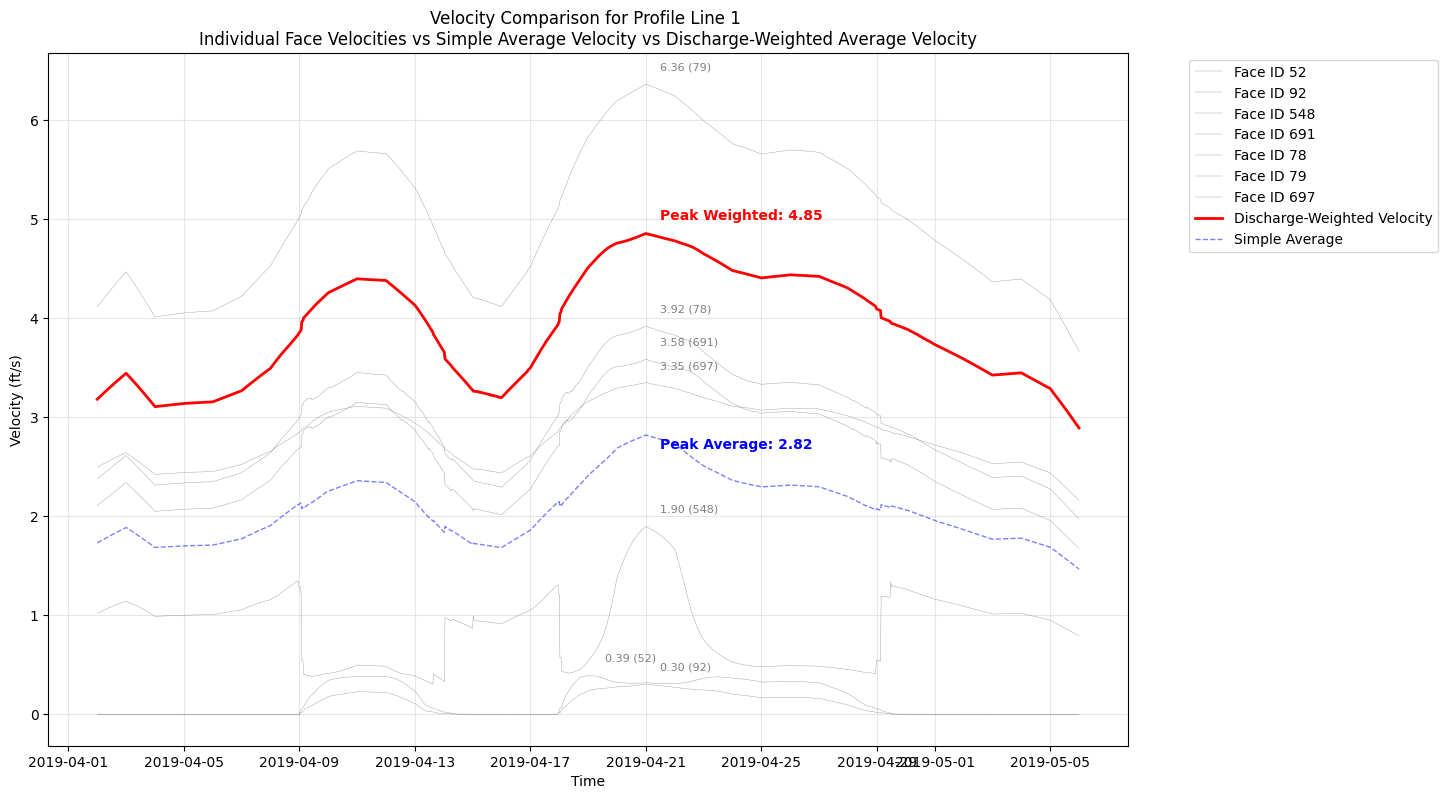


Velocity Comparison for Profile Line 1 
Individual Face Velocities vs Simple Average Velocity vs Discharge-Weighted Average Velocity
Number of faces: 7

Discharge-Weighted Velocity Statistics:
Mean: 3.89 ft/s
Max: 4.85 ft/s
Min: 2.89 ft/s

Simple Average Velocity Statistics:
Mean: 2.07 ft/s
Max: 2.82 ft/s
Min: 1.47 ft/s

Generating comparison plot for profile: Profile Line 2
Calculating weighted velocity...
Input DataFrame columns: ['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']


Calculated velocities:
                 time  weighted_velocity
0 2019-04-02 00:00:00           2.401040
1 2019-04-02 00:30:00           2.403080
2 2019-04-02 01:00:00           2.407171
3 2019-04-02 01:30:00           2.411040
4 2019-04-02 02:00:00           2.414976


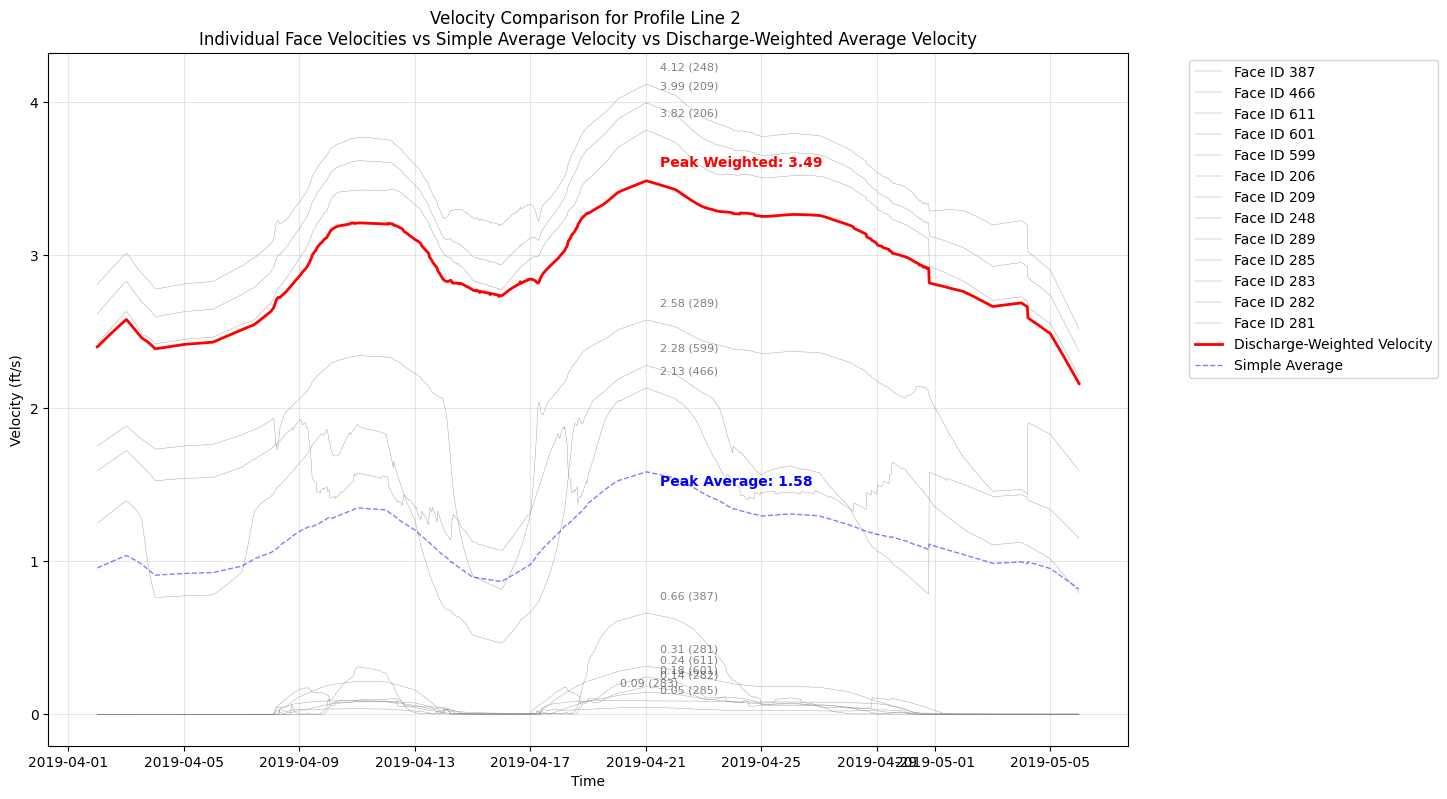


Velocity Comparison for Profile Line 2 
Individual Face Velocities vs Simple Average Velocity vs Discharge-Weighted Average Velocity
Number of faces: 13

Discharge-Weighted Velocity Statistics:
Mean: 2.93 ft/s
Max: 3.49 ft/s
Min: 2.16 ft/s

Simple Average Velocity Statistics:
Mean: 1.16 ft/s
Max: 1.58 ft/s
Min: 0.82 ft/s

Generating comparison plot for profile: Profile Line 3
Calculating weighted velocity...
Input DataFrame columns: ['time', 'face_id', 'face_velocity', 'face_flow', 'profile_name', 'face_order']


Calculated velocities:
                 time  weighted_velocity
0 2019-04-02 00:00:00           2.370525
1 2019-04-02 00:30:00           2.371187
2 2019-04-02 01:00:00           2.375672
3 2019-04-02 01:30:00           2.379937
4 2019-04-02 02:00:00           2.384298


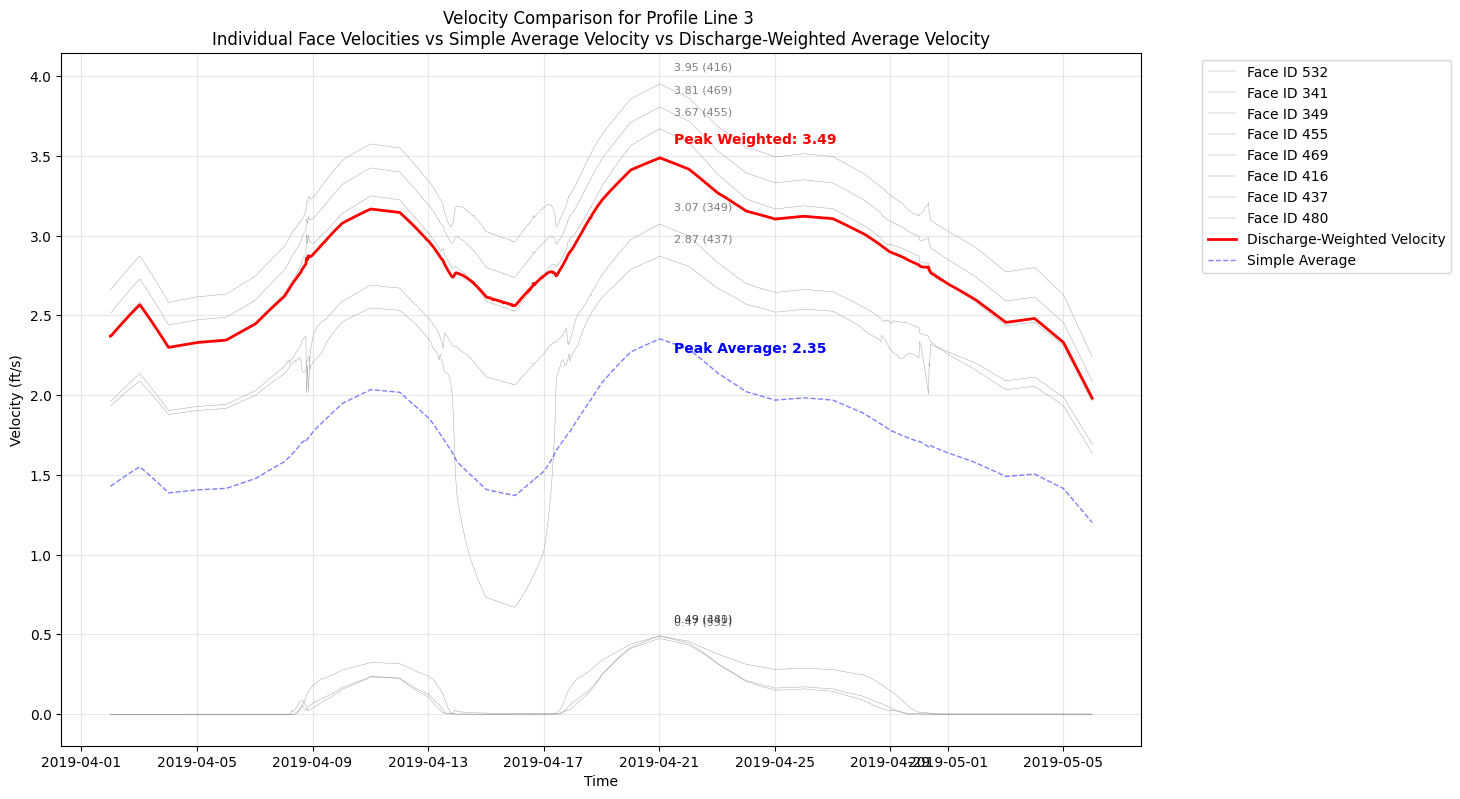


Velocity Comparison for Profile Line 3 
Individual Face Velocities vs Simple Average Velocity vs Discharge-Weighted Average Velocity
Number of faces: 8

Discharge-Weighted Velocity Statistics:
Mean: 2.83 ft/s
Max: 3.49 ft/s
Min: 1.98 ft/s

Simple Average Velocity Statistics:
Mean: 1.75 ft/s
Max: 2.35 ft/s
Min: 1.20 ft/s


In [42]:
# Create plots comparing discharge-weighted velocity and simple average for each profile line
for profile_name, profile_df in profile_time_series.items():
    
    print(f"\nGenerating comparison plot for profile: {profile_name}")
    
    # Calculate discharge-weighted velocity
    weighted_velocities = calculate_discharge_weighted_velocity(profile_df)
    weighted_velocities['time'] = pd.to_datetime(weighted_velocities['time'])
    
    # Calculate simple average velocity for each timestep
    simple_averages = profile_df.groupby('time')['face_velocity'].mean().reset_index()
    simple_averages['time'] = pd.to_datetime(simple_averages['time'])
    
    # Create figure for comparison plot
    plt.figure(figsize=(16, 9))
    
    # Plot individual face velocities with thin lines
    for face_id in profile_df['face_id'].unique():
        face_data = profile_df[profile_df['face_id'] == face_id]
        plt.plot(face_data['time'], 
                face_data['face_velocity'], 
                alpha=0.8,  # More transparent
                linewidth=0.3,  # Thinner line
                color='gray',  # Consistent color
                label=f'Face ID {face_id}')
        
        # Find and annotate peak value for each face
        peak_idx = face_data['face_velocity'].idxmax()
        peak_time = face_data.loc[peak_idx, 'time']
        peak_vel = face_data.loc[peak_idx, 'face_velocity']
        plt.annotate(f'{peak_vel:.2f} ({face_id})',
                    xy=(peak_time, peak_vel),
                    xytext=(10, 10),
                    textcoords='offset points',
                    fontsize=8,
                    alpha=0.5)
    
    # Plot discharge-weighted velocity
    plt.plot(weighted_velocities['time'], 
            weighted_velocities['weighted_velocity'], 
            color='red', 
            alpha=1.0, 
            linewidth=2,
            label='Discharge-Weighted Velocity')
    
    # Find and annotate peak weighted velocity
    peak_idx = weighted_velocities['weighted_velocity'].idxmax()
    peak_time = weighted_velocities.loc[peak_idx, 'time']
    peak_vel = weighted_velocities.loc[peak_idx, 'weighted_velocity']
    plt.annotate(f'Peak Weighted: {peak_vel:.2f}',
                xy=(peak_time, peak_vel),
                xytext=(10, 10),
                textcoords='offset points',
                color='red',
                fontweight='bold')
    
    # Plot simple average
    plt.plot(simple_averages['time'], 
            simple_averages['face_velocity'], 
            color='blue', 
            alpha=0.5, 
            linewidth=1,
            linestyle='--',
            label='Simple Average')
    
    # Find and annotate peak simple average
    peak_idx = simple_averages['face_velocity'].idxmax()
    peak_time = simple_averages.loc[peak_idx, 'time']
    peak_vel = simple_averages.loc[peak_idx, 'face_velocity']
    plt.annotate(f'Peak Average: {peak_vel:.2f}',
                xy=(peak_time, peak_vel),
                xytext=(10, -10),
                textcoords='offset points',
                color='blue',
                fontweight='bold')
    
    # Configure plot
    plt.title(f'Velocity Comparison for {profile_name} \nIndividual Face Velocities vs Simple Average Velocity vs Discharge-Weighted Average Velocity')
    plt.xlabel('Time')
    plt.ylabel('Velocity (ft/s)')
    plt.grid(True, alpha=0.3)
    
    # Add legend with better placement
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to accommodate legend and stats
    plt.subplots_adjust(right=0.8)
    
    # Save plot to file
    plot_file = ras.project_folder / f"{profile_name}_velocity_comparison.png"
    plt.savefig(plot_file, bbox_inches='tight', dpi=300)
    plt.show()
    
    # Print detailed comparison
    print(f"\nVelocity Comparison for {profile_name} \nIndividual Face Velocities vs Simple Average Velocity vs Discharge-Weighted Average Velocity")
    print(f"Number of faces: {profile_df['face_id'].nunique()}")
    print("\nDischarge-Weighted Velocity Statistics:")
    print(f"Mean: {weighted_velocities['weighted_velocity'].mean():.2f} ft/s")
    print(f"Max: {weighted_velocities['weighted_velocity'].max():.2f} ft/s")
    print(f"Min: {weighted_velocities['weighted_velocity'].min():.2f} ft/s")
    print("\nSimple Average Velocity Statistics:")
    print(f"Mean: {simple_averages['face_velocity'].mean():.2f} ft/s")
    print(f"Max: {simple_averages['face_velocity'].max():.2f} ft/s")
    print(f"Min: {simple_averages['face_velocity'].min():.2f} ft/s")

2025-12-16 21:40:48 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:48 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:48 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:48 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:49 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:49 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf


2025-12-16 21:40:49 - ras_commander.hdf.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF file projection attribute: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\Chippewa_2D.g01.hdf
2. RASMapper projection file C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Chippewa_2D_13\.Winona_Upload\LifeSim model\Winona Levee SQRA 2019\RAS\AW\MMC_Projection.prj found in RASMapper file, but was invalid
To fix this:
1. Open RASMapper
2. Click Map > Set Projection
3. Select an appropriate projection file or coordinate system
4. Save the RASMapper project



Example: Extracting mesh cell faces near profile lines
First few rows of mesh cell faces:


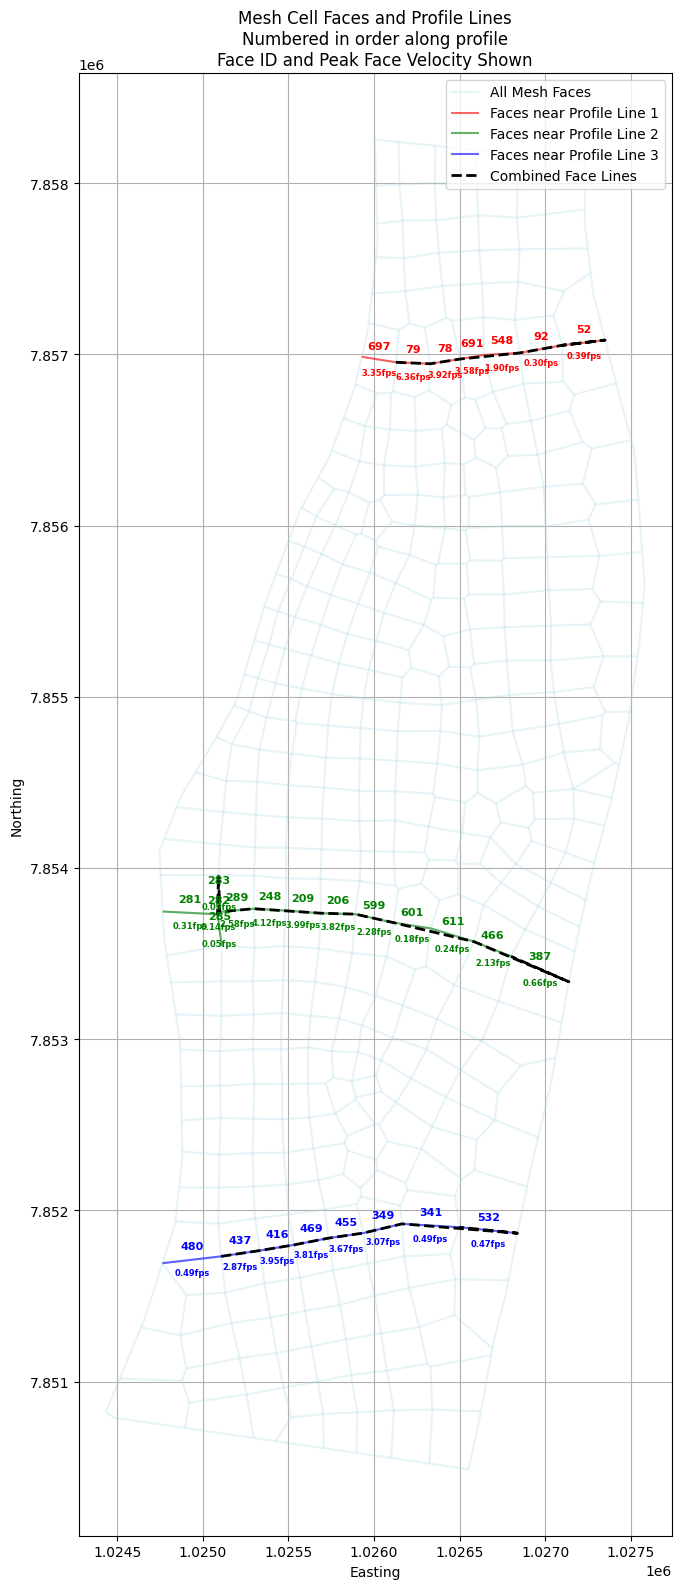


Original ordered faces near profile lines:

Combined profile-to-faceline results:


,profile_name,geometry
0,Profile Line 1,"LINESTRING (1027100.412 7857052.854, 1027350.3..."
1,Profile Line 2,"LINESTRING (1026801.09 7853483.399, 1027138.39..."
2,Profile Line 3,"LINESTRING (1026498.193 7851901.653, 1026838.2..."


In [43]:
# Example: Extracting mesh cell faces near profile lines
print("\nExample: Extracting mesh cell faces near profile lines")

# Get mesh cell faces using HdfMesh class
mesh_cell_faces = HdfMesh.get_mesh_cell_faces(geom_hdf_path)

# Display the first few rows of the mesh cell faces DataFrame
print("First few rows of mesh cell faces:")
mesh_cell_faces

# Load the GeoJSON file for profile lines
geojson_path = Path(r'data/profile_lines_chippewa2D.geojson')  # Update with the correct path
profile_lines_gdf = gpd.read_file(geojson_path)

# Set the Coordinate Reference System (CRS) to EPSG:5070
profile_lines_gdf = profile_lines_gdf.set_crs(epsg=5070, allow_override=True)

# Initialize a dictionary to store faces near each profile line
faces_near_profile_lines = {}

# Define distance threshold (10 ft converted to meters)
distance_threshold = 10
angle_threshold = 60  # degrees

# Function to calculate the smallest angle between two lines or line segments.
def calculate_angle(line):
    if isinstance(line, LineString):
        x_diff = line.xy[0][-1] - line.xy[0][0]
        y_diff = line.xy[1][-1] - line.xy[1][0]
    else:
        x_diff = line[1][0] - line[0][0]
        y_diff = line[1][1] - line[0][1]
    
    angle = np.degrees(np.arctan2(y_diff, x_diff))
    return angle % 360 if angle >= 0 else (angle + 360) % 360

# Function to break line into segments
def break_line_into_segments(line, segment_length):
    segments = []
    segment_angles = []
    
    distances = np.arange(0, line.length, segment_length)
    if distances[-1] != line.length:
        distances = np.append(distances, line.length)
        
    for i in range(len(distances)-1):
        point1 = line.interpolate(distances[i])
        point2 = line.interpolate(distances[i+1])
        segment = LineString([point1, point2])
        segments.append(segment)
        segment_angles.append(calculate_angle([point1.coords[0], point2.coords[0]]))
        
    return segments, segment_angles

# Function to calculate angle difference accounting for 180 degree equivalence
def angle_difference(angle1, angle2):
    diff = abs(angle1 - angle2) % 180
    return min(diff, 180 - diff)

# Function to order faces along profile line
def order_faces_along_profile(profile_line, faces_gdf):
    profile_start = Point(profile_line.coords[0])
    
    faces_with_dist = []
    for idx, face in faces_gdf.iterrows():
        face_start = Point(face.geometry.coords[0])
        dist = profile_start.distance(face_start)
        faces_with_dist.append((idx, dist))
    
    faces_with_dist.sort(key=lambda x: x[1])
    return [x[0] for x in faces_with_dist]

# Function to combine ordered faces into single linestring
def combine_faces_to_linestring(ordered_faces_gdf):
    coords = []
    for _, face in ordered_faces_gdf.iterrows():
        if not coords:  # First face - add all coordinates
            coords.extend(list(face.geometry.coords))
        else:  # Subsequent faces - add only end coordinate
            coords.append(face.geometry.coords[-1])
    return LineString(coords)

# Initialize GeoDataFrame for final profile-to-faceline results
profile_to_faceline = gpd.GeoDataFrame(columns=['profile_name', 'geometry'], crs=profile_lines_gdf.crs)

# Iterate through each profile line
for index, profile_line in profile_lines_gdf.iterrows():
    profile_geom = profile_line.geometry
    
    # Break profile line into segments
    segments, segment_angles = break_line_into_segments(profile_geom, distance_threshold)
    
    # Initialize set to store nearby faces
    nearby_faces = set()
    
    # For each face, check distance to segments and angle difference
    for face_idx, face in mesh_cell_faces.iterrows():
        face_geom = face.geometry
        
        if isinstance(face_geom, LineString):
            face_angle = calculate_angle(face_geom)
            
            for segment, segment_angle in zip(segments, segment_angles):
                if face_geom.distance(segment) <= distance_threshold:
                    if angle_difference(face_angle, segment_angle) <= angle_threshold:
                        nearby_faces.add(face_idx)
                        break
    
    # Convert the set of indices back to a GeoDataFrame
    nearby_faces_gdf = mesh_cell_faces.loc[list(nearby_faces)]
    
    # Order faces along profile line
    ordered_indices = order_faces_along_profile(profile_geom, nearby_faces_gdf)
    ordered_faces_gdf = nearby_faces_gdf.loc[ordered_indices]
    
    # Combine ordered faces into single linestring
    combined_linestring = combine_faces_to_linestring(ordered_faces_gdf)
    
    # Add to profile_to_faceline GeoDataFrame
    new_row = gpd.GeoDataFrame({'profile_name': [profile_line['Name']], 
                               'geometry': [combined_linestring]}, 
                              crs=profile_lines_gdf.crs)
    profile_to_faceline = pd.concat([profile_to_faceline, new_row], ignore_index=True)
    
    # Store the ordered faces in the dictionary
    faces_near_profile_lines[profile_line['Name']] = ordered_faces_gdf

# Plot the results
fig, ax = plt.subplots(figsize=(24, 16))

# Plot all mesh cell faces in light blue
mesh_cell_faces.plot(ax=ax, color='lightblue', alpha=0.3, edgecolor='k', label='All Mesh Faces')

# Plot selected faces for each profile line with numbers and velocities
colors = ['red', 'green', 'blue']
for (profile_name, faces), color in zip(faces_near_profile_lines.items(), colors):
    if not faces.empty:
        faces.plot(ax=ax, color=color, alpha=0.6, label=f'Faces near {profile_name}')
        
        # Get velocity data for this profile from profile_time_series
        profile_data = profile_time_series[profile_name]
        
        # Add face_id above and peak velocity below for each face
        for idx, face in faces.iterrows():
            midpoint = face.geometry.interpolate(0.5, normalized=True)
            
            # Get peak velocity for this face
            face_velocities = profile_data[profile_data['face_id'] == face['face_id']]['face_velocity']
            peak_velocity = face_velocities.max() if not face_velocities.empty else 0.0
            # Add face_id above the face
            ax.text(midpoint.x, midpoint.y + 50,  # Adjust the +50 offset as needed
                   f"{face['face_id']}", 
                   color=color, 
                   fontweight='bold',
                   fontsize=8,
                   ha='center', 
                   va='bottom')
            
            # Add peak velocity below the face
            ax.text(midpoint.x, midpoint.y - 50,  # Adjust the -50 offset as needed
                   f"{peak_velocity:.2f}fps", 
                   color=color, 
                   fontweight='bold',
                   fontsize=6,
                   ha='center', 
                   va='top')


# Plot the combined linestrings
profile_to_faceline.plot(ax=ax, color='black', linewidth=2, 
                        linestyle='--', label='Combined Face Lines')

# Set labels and title
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_title('Mesh Cell Faces and Profile Lines\nNumbered in order along profile\nFace ID and Peak Face Velocity Shown')

# Add grid and legend
ax.grid(True)
ax.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Display the results
print("\nOriginal ordered faces near profile lines:")
faces_near_profile_lines

print("\nCombined profile-to-faceline results:")
profile_to_faceline

NOTE:  We are using the face normal velocity that is available in the HDF.  This will only be accurate if you pick cell faces that are perpendicular to flow.  Depending on the application, a more robust calculation may be required. 